SMILES Predictor model

2024-07-04 14:35:39,471 - INFO - Processing 0/10812 SMILES
2024-07-04 14:35:42,859 - INFO - Processing 1000/10812 SMILES
2024-07-04 14:35:45,979 - INFO - Processing 2000/10812 SMILES
2024-07-04 14:35:49,019 - INFO - Processing 3000/10812 SMILES
2024-07-04 14:35:51,865 - INFO - Processing 4000/10812 SMILES
2024-07-04 14:35:54,857 - INFO - Processing 5000/10812 SMILES
2024-07-04 14:35:58,123 - INFO - Processing 6000/10812 SMILES
[14:35:59] WARNING: not removing hydrogen atom without neighbors
2024-07-04 14:36:01,258 - INFO - Processing 7000/10812 SMILES
2024-07-04 14:36:04,468 - INFO - Processing 8000/10812 SMILES
2024-07-04 14:36:07,452 - INFO - Processing 9000/10812 SMILES
2024-07-04 14:36:10,449 - INFO - Processing 10000/10812 SMILES
2024-07-04 14:36:12,937 - INFO - Processing 0/4564 AXL-Kinase-Inhibitor SMILES
2024-07-04 14:36:13,432 - INFO - Processing 100/4564 AXL-Kinase-Inhibitor SMILES
2024-07-04 14:36:13,862 - INFO - Processing 200/4564 AXL-Kinase-Inhibitor SMILES
2024-07-04 14:

        AlogP  PolarSurfaceArea  HBA  HBD       Chi0     Kappa1    TPSA  \
5805   4.3814             61.60    5    0  14.629392  16.374585   61.60   
12036  3.2478            166.47    9    3  33.404684  31.605977  166.47   
2596   1.6603             64.35    4    1  12.087576  11.193326   64.35   
8295   0.1385             43.37    3    0   6.568914   7.140000   43.37   
573    1.6402             86.63    3    3  12.836499  13.315574   86.63   

       MolLogP  PEOE_VSA1  PEOE_VSA2  ...  FP_2038  FP_2039  FP_2040  FP_2041  \
5805    4.3814   9.047494  10.114318  ...        0        0        0        0   
12036   3.2478  25.956803  14.383612  ...        0        0        0        1   
2596    1.6603  14.410490   0.000000  ...        0        0        0        0   
8295    0.1385   4.736863   4.794537  ...        0        0        0        0   
573     1.6402  15.529843   9.589074  ...        0        0        0        0   

       FP_2042  FP_2043  FP_2044  FP_2045  FP_2046  FP_2047  


2024-07-04 14:36:57,710 - INFO - Epoch 1/50, Loss: 0.1242
2024-07-04 14:36:58,788 - INFO - Training Accuracy: CHEMBL: 86.16%, AXL: 87.36%
2024-07-04 14:36:59,004 - INFO - Test Accuracy: CHEMBL: 86.46%, AXL: 86.88%

2024-07-04 14:37:09,481 - INFO - Epoch 2/50, Loss: 0.0873
2024-07-04 14:37:10,797 - INFO - Training Accuracy: CHEMBL: 93.15%, AXL: 78.42%
2024-07-04 14:37:11,097 - INFO - Test Accuracy: CHEMBL: 92.87%, AXL: 77.82%

2024-07-04 14:37:21,826 - INFO - Epoch 3/50, Loss: 0.0762
2024-07-04 14:37:23,046 - INFO - Training Accuracy: CHEMBL: 90.76%, AXL: 91.03%
2024-07-04 14:37:23,323 - INFO - Test Accuracy: CHEMBL: 90.02%, AXL: 89.66%

2024-07-04 14:37:33,639 - INFO - Epoch 4/50, Loss: 0.0646
2024-07-04 14:37:34,802 - INFO - Training Accuracy: CHEMBL: 92.89%, AXL: 92.14%
2024-07-04 14:37:35,059 - INFO - Test Accuracy: CHEMBL: 92.33%, AXL: 90.94%

2024-07-04 14:37:45,932 - INFO - Epoch 5/50, Loss: 0.0547
2024-07-04 14:37:47,213 - INFO - Training Accuracy: CHEMBL: 94.97%, AXL: 92.95%
20

train: (0.09963493762956871, 0.9790312093628089)
test: (0.12238775524720935, 0.9591968911917098)


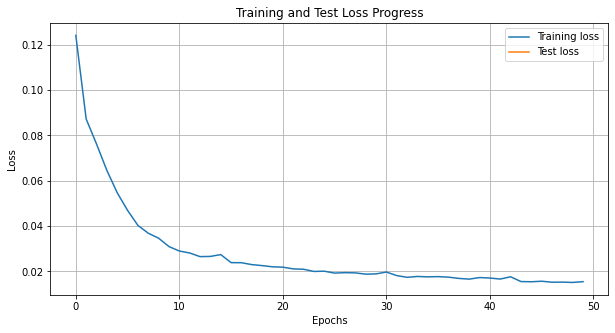

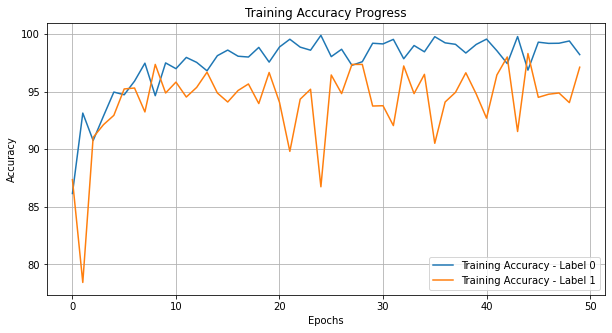

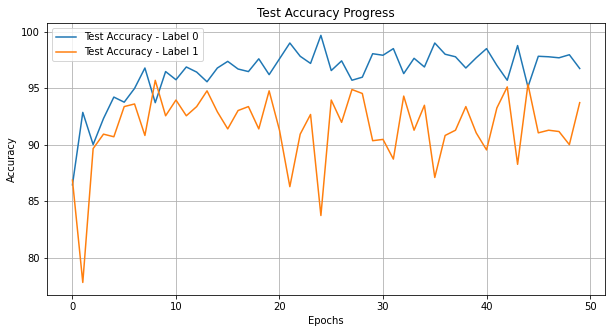


 Modell erfolgreich gespeichert unter: model_predictor_0407.pth
predict: 100%|██████████| 769/769 [00:01<00:00, 411.63it/s]
torch.Size([12300]) torch.Size([12300])
predict: 100%|██████████| 193/193 [00:00<00:00, 487.44it/s]
torch.Size([3076]) torch.Size([3076])


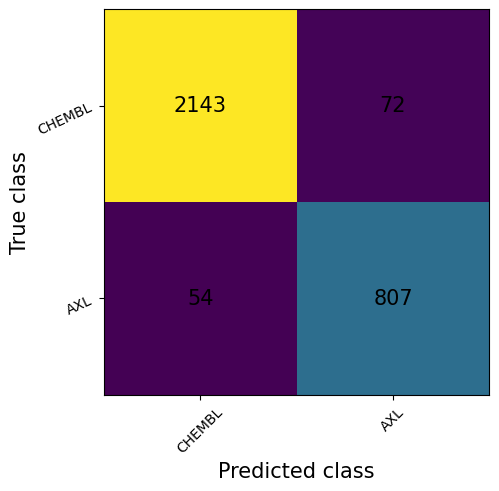

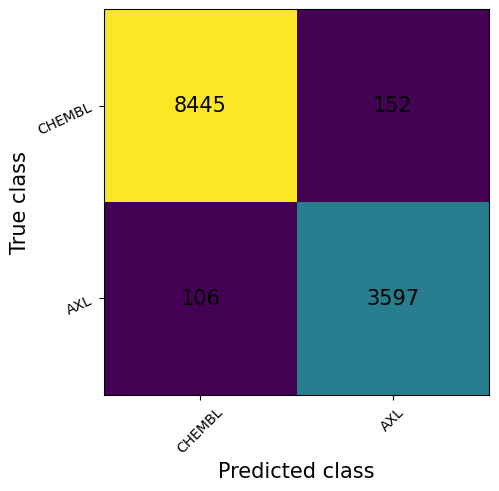

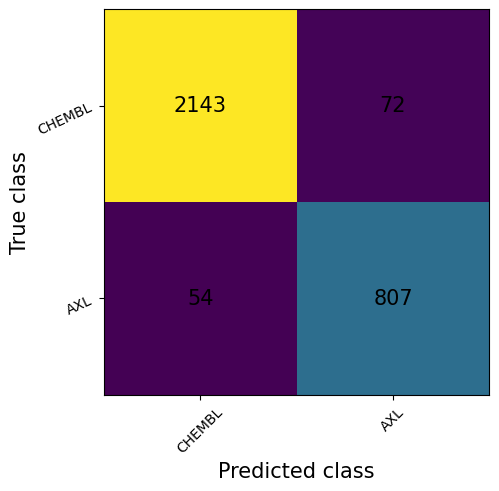

In [14]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors, rdPartialCharges
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import logging
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassConfusionMatrix
from tqdm import tqdm
import sys


# User-defined parameters
SMILES_DATA_PATH = 'C:\\Users\\SchockWav3\\Desktop\\Masterarbeit\\chembl_smiles.txt'
SMILES_AXL_INHIBITORS_PATH = 'C:\\Users\\SchockWav3\\Desktop\\Masterarbeit\\ChemblNIHDatensatzAXLKinase.txt'
SAVE_MODEL_PATH = 'C:\\Users\\SchockWav3\\Desktop\\Masterarbeit\\model_predictor_2508.pth'
BATCH_SIZE = 64
LEARNING_RATE = 0.00005
NUM_EPOCHS = 150
EARLY_STOPPING_ACTIVE = True
TARGET_ACCURACY_CHEMBL = 97.2
TARGET_ACCURACY_AXL = 99.9



# 1. Set device for computation (GPU if available, otherwise CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Calculate with: {torch.cuda.get_device_name(0)}")

else:
    device = torch.device("cpu")
    print(f"Calculate with: {device}")


# Function to read SMILES strings from a .txt file
def load_data(file_path):
    with open(file_path, 'r') as file:
        smiles_list = file.read().splitlines()
    return smiles_list


# 2. Define file paths for the datasets
smiles_data_path = SMILES_DATA_PATH    
smiles_axl_inhibitors_path = SMILES_AXL_INHIBITORS_PATH


# Load SMILES data
smiles_data = load_data(smiles_data_path)
smiles_axl_inhibitors = load_data(smiles_axl_inhibitors_path)



# 3. Function to calculate descriptors for a given SMILES string
def calculate_descriptors(smiles):
    """
    Calculates molecular descriptors and Morgan fingerprints for a given SMILES string.

    Args:
        smiles (str): A SMILES string representing a chemical compound.

    Returns:
        dict: A dictionary containing calculated descriptors and fingerprints.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # If the SMILES string is invalid, skip it
    
    descriptors = {
        "MorganFingerprint":    AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048),
        "AlogP":                Descriptors.MolLogP(mol),
        "PolarSurfaceArea":     Descriptors.TPSA(mol),
        "HBA":                  Descriptors.NumHAcceptors(mol),
        "HBD":                  Descriptors.NumHDonors(mol),
        "Chi0":                 Descriptors.Chi0(mol),
        "Kappa1":               Descriptors.Kappa1(mol),
        "TPSA":                 Descriptors.TPSA(mol),
        "MolLogP":              Descriptors.MolLogP(mol),
        "PEOE_VSA1":            Descriptors.PEOE_VSA1(mol),
        "PEOE_VSA2":            Descriptors.PEOE_VSA2(mol),
        "PEOE_VSA3":            Descriptors.PEOE_VSA3(mol),
        "PEOE_VSA4":            Descriptors.PEOE_VSA4(mol),
        "PEOE_VSA5":            Descriptors.PEOE_VSA5(mol),
        "PEOE_VSA6":            Descriptors.PEOE_VSA6(mol),
        "PEOE_VSA7":            Descriptors.PEOE_VSA7(mol),
        "PEOE_VSA8":            Descriptors.PEOE_VSA8(mol),
        "PEOE_VSA9":            Descriptors.PEOE_VSA9(mol),
        "PEOE_VSA10":           Descriptors.PEOE_VSA10(mol),
        "PEOE_VSA11":           Descriptors.PEOE_VSA11(mol),
        "PEOE_VSA12":           Descriptors.PEOE_VSA12(mol),
        "PEOE_VSA13":           Descriptors.PEOE_VSA13(mol),
        "PEOE_VSA14":           Descriptors.PEOE_VSA14(mol),
        "MolecularWeight":      Descriptors.MolWt(mol),
        "NumRotatableBonds":    Descriptors.NumRotatableBonds(mol),
        "NumAromaticRings":     Descriptors.NumAromaticRings(mol),
        #"MaxPartialCharge":     max_partial_charge,
        #"MinPartialCharge":     min_partial_charge,
        "FractionCSP3":         Descriptors.FractionCSP3(mol),
        #"RadiusOfGyration":     rdMolDescriptors.CalcRadiusOfGyration(mol),
        #"Polarizability":       rdMolDescriptors.CalcExactMolWt(mol),
        #"MolVolume":            Descriptors.MolWt(mol),
        #"MolWt":                Descriptors.MolWt(mol),
        "HeavyAtomCount":       Descriptors.HeavyAtomCount(mol),
        "NHOHCount":            Descriptors.NHOHCount(mol),
        "NOCount":              Descriptors.NOCount(mol),
        "NumHeteroatoms":       Descriptors.NumHeteroatoms(mol),
        "NumRadicalElectrons":  Descriptors.NumRadicalElectrons(mol),
        "NumValenceElectrons":  Descriptors.NumValenceElectrons(mol),
        "RingCount":            Descriptors.RingCount(mol),
        "BalabanJ":             Descriptors.BalabanJ(mol),
        "BertzCT":              Descriptors.BertzCT(mol),
        "Chi1":                 Descriptors.Chi1(mol),
        "Chi0n":                Descriptors.Chi0n(mol),
        "Chi0v":                Descriptors.Chi0v(mol),
        "Chi1n":                Descriptors.Chi1n(mol),
        "Chi1v":                Descriptors.Chi1v(mol),
        "Kappa2":               Descriptors.Kappa2(mol),
        "Kappa3":               Descriptors.Kappa3(mol),
        "HallKierAlpha":        Descriptors.HallKierAlpha(mol),
    }
    return descriptors


# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
 

# Calculate descriptors for the loaded SMILES data
data = []

for index, smiles in enumerate(smiles_data):
    if index % 1000 == 0:
        logging.info(f"Processing {index}/{len(smiles_data)} SMILES")
    descriptors = calculate_descriptors(smiles)
    if descriptors is not None:
        descriptors["SMILES"] = smiles
        descriptors["Target"] = 0  # Other molecules
        data.append(descriptors)


for index, smiles in enumerate(smiles_axl_inhibitors):
    if index % 100 == 0:
        logging.info(f"Processing {index}/{len(smiles_axl_inhibitors)} AXL-Kinase-Inhibitor SMILES")
    descriptors = calculate_descriptors(smiles)
    if descriptors is not None:
        descriptors["SMILES"] = smiles
        descriptors["Target"] = 1  # AXL-Kinase-Inhibitors
        data.append(descriptors)


# Create a DataFrame from the calculated descriptors
df = pd.DataFrame(data)

# Convert Morgan fingerprints into a separate DataFrame
fingerprints = np.array([list(fp) for fp in df["MorganFingerprint"].values])
fingerprints_df = pd.DataFrame(fingerprints, columns=[f"FP_{i}" for i in range(fingerprints.shape[1])])

# Add Morgan fingerprints to the main DataFrame
df = df.drop(columns=["MorganFingerprint"])
df = pd.concat([df, fingerprints_df], axis=1)


# Performs oversampling on the AXL-Kinase-Inhibitors dataset
axl_data = df[df['Target'] == 1]
df = pd.concat([df, axl_data] * 3)  # Duplicate the AXL data three times to address class imbalance
print(df['Target'].value_counts())


# 4. Train-test split
X = df.drop(columns=["SMILES", "Target"])
y = df["Target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Debugging: Display some of the training data
print(X_train.head())
print(y_train.head())

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

print(y_train_tensor.shape)


# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# 5. Define model architecture
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 8)
        self.bn5 = nn.BatchNorm1d(8)
        self.fc6 = nn.Linear(8, 2)
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)  #Activationfunction
        return x

input_size = X_train.shape[1]
model = MLP(input_size)

# Move model to the selected device
model.to(device)

# Define class weights (optional, if needed for imbalance correction)
class_weights = torch.tensor([1.0, len(y_train) / sum(y_train)]).to(torch.float32)
#class_weights = torch.tensor([1.0, 12.0]).to(torch.float32)


# Focal Cross Entropy loss function (Andreas Dominik)
def focal_CE_loss(scores, labels, gamma=2.0):
    """
    Calculates the Focal Loss, a modified version of the Cross-Entropy Loss, to handle imbalanced data.

    Args:
        scores (torch.Tensor): The logits predicted by the model.
        labels (torch.Tensor): The actual labels.
        gamma (float, optional): A hyperparameter to adjust the weighting of difficult examples. Default is 2.0.

    Returns:
        float: The computed Focal Loss.
    """
    labels = labels.long()
    sm = F.softmax(scores, dim=-1)
    p = torch.gather(sm, dim=1, index=labels.unsqueeze(-1)).squeeze(-1)
    nll = F.cross_entropy(scores, labels, reduction='none')
    fce = torch.pow((1-p),gamma) * nll
    return torch.mean(fce)


# Define loss function and optimizer
#criterion = F.cross_entropy
criterion = focal_CE_loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


# Lists for storing losses and accuracies
train_losses = []
test_losses = []
train_label_accuracies = {0: [], 1: []}
test_label_accuracies = {0: [], 1: []}


# Parameters for Early Stopping
early_stopping_active = EARLY_STOPPING_ACTIVE  # Enables Early Stopping
target_accuracy_chembl = TARGET_ACCURACY_CHEMBL  # Target accuracy in percent for CHEMBL
target_accuracy_axl = TARGET_ACCURACY_AXL  # Target accuracy in percent for AXL kinase inhibitors

# 6. Training the model
num_epochs = NUM_EPOCHS


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    logging.info(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


    model.eval()
    test_running_loss = 0.0
    with torch.no_grad():
        train_correct = {0: 0, 1: 0}
        train_total = {0: 0, 1: 0}
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            for label in [0, 1]:
                train_total[label] += (labels == label).sum().item()
                train_correct[label] += ((predicted == labels) & (labels == label)).sum().item()
        
        train_accuracy = {label: 100 * train_correct[label] / train_total[label] if train_total[label] > 0 else 0 for label in [0, 1]}
        logging.info(f"Training Accuracy: CHEMBL: {train_accuracy[0]:.2f}%, AXL: {train_accuracy[1]:.2f}%")
        for label in [0, 1]:
            train_label_accuracies[label].append(train_accuracy[label])


        test_correct = {0: 0, 1: 0}
        test_total = {0: 0, 1: 0}
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * inputs.size(0)


            _, predicted = torch.max(outputs, 1)
            for label in [0, 1]:
                test_total[label] += (labels == label).sum().item()
                test_correct[label] += ((predicted == labels) & (labels == label)).sum().item()
        
        test_epoch_loss = test_running_loss / len(test_loader.dataset)
        test_losses.append(test_epoch_loss)
        
        test_accuracy = {label: 100 * test_correct[label] / test_total[label] if test_total[label] > 0 else 0 for label in [0, 1]}
        logging.info(f"Test Accuracy: CHEMBL: {test_accuracy[0]:.2f}%, AXL: {test_accuracy[1]:.2f}%\n")
        for label in [0, 1]:
            test_label_accuracies[label].append(test_accuracy[label])
        
        # Check early stopping condition
        if early_stopping_active and test_accuracy[0] >= target_accuracy_chembl and test_accuracy[1] >= target_accuracy_axl:
            print(f"Early stopping activated. Test accuracies reached: CHEMBL {test_accuracy[0]:.2f}%, AXL {test_accuracy[1]:.2f}%.")
            break  # End training


# Accuracy calculation function (Andreas Dominik)
def acc(scores, labels):
    classes = torch.argmax(scores, dim=-1)
    acc = torch.mean((classes == labels).float())
    return acc.item()


# Function to calculate loss and accuracy (Andreas Dominik)
def loss_acc(mdl, data, lossfn=F.cross_entropy, accfn=acc, device=torch.device("cpu")):
    loss = 0.0
    acc = 0.0
    mdl = mdl.to(device)
    for x, y in data:
        x = x.to(device)
        y = y.to(device)
        s = mdl(x)
        loss = loss + lossfn(s, y).item()
        acc = acc + accfn(s, y)
    return loss/len(data), acc/len(data)


print("train:", loss_acc(model, train_loader))
print("test:", loss_acc(model, test_loader))


# 7. Function to extract the most important features based on the first layer's weights
def get_feature_importance(model, feature_names, top_n=None, prefix=None):
    """
    Extracts the most important features based on the weights of the first layer of the model.

    Args:
        model (nn.Module): The trained neural network model.
        feature_names (List[str]): A list of input feature names.
        top_n (int, optional): The number of top features to extract. If None, all features are considered.
        prefix (str, optional): A prefix to filter specific features (e.g., 'FP_' for Morgan fingerprints).

    Returns:
        Tuple[List[str], List[float]]: Two lists containing the names of the most important features and their corresponding weights.
    """
    # Extract weights from the first layer
    first_layer_weights = model.fc1.weight.detach().cpu().numpy()
    # Calculate mean absolute weights across all neurons in the first layer
    mean_abs_weights = np.mean(np.abs(first_layer_weights), axis=0)
    
    # Filter features based on the prefix
    if prefix is not None:
        indices = [i for i, name in enumerate(feature_names) if name.startswith(prefix)]
    else:
        indices = [i for i, name in enumerate(feature_names) if not name.startswith('FP_')]
    
    weights = mean_abs_weights[indices]
    names = [feature_names[i] for i in indices]
    
    # Sort features by importance
    sorted_indices = np.argsort(weights)[::-1]
    
    if top_n:
        sorted_indices = sorted_indices[:top_n]
    
    # Extract top features and their weights
    top_features = [names[i] for i in sorted_indices]
    top_weights = weights[sorted_indices]
    return top_features, top_weights


# 8. Define path for saving the model
save_model_path = SAVE_MODEL_PATH

# Save the model
torch.save(model.state_dict(), save_model_path)
print(f"\n Modell erfolgreich gespeichert unter: {save_model_path}")


# 9. Plotting functions
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Test loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Progress')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_label_accuracy(label_accuracies, label_name):
    plt.figure(figsize=(10, 5))
    for label in [0, 1]:
        plt.plot(label_accuracies[label], label=f'{label_name} Accuracy - Label {label}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{label_name} Accuracy Progress')
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot confusion matrix using TorchMetrics (Andreas Dominik)
def plot_confusion_matrix(mdl, data, class_names=None, device=torch.device("cpu")):

    preds = torch.tensor([]).to(device)
    targets = torch.tensor([]).to(device)
    mdl = mdl.to(device)
    mdl.eval()

    pbar = tqdm(data, desc="predict", file=sys.stdout)
    for x,y in pbar:
        x,y = x.to(device), y.to(device)
        p = mdl(x)
        preds = torch.cat((preds, torch.argmax(p, dim=1)), dim=0)
        targets = torch.cat((targets, y), dim=0)

    preds, targets = preds.to("cpu"), targets.to("cpu")
    print(preds.shape, targets.shape)
    cm = MulticlassConfusionMatrix(num_classes=2)
    cm.update(preds, targets)
    fig, _ = cm.plot(labels=class_names)
    return fig


# Plotting function for feature importances
def plot_feature_importance(top_features, top_weights, title):
    plt.figure(figsize=(14, 10))
    plt.barh(range(len(top_features)), top_weights[::-1], align='center')
    plt.yticks(range(len(top_features)), top_features[::-1], fontsize=8)
    plt.xlabel('Mean Absolute Weight')
    plt.title(title)
    plt.show()


# Extract feature names
feature_names = X_train.columns

# Calculate the importance of descriptors (without prefix), Morgan-Fingerprints (with prefix 'FP_')
top_features_desc, top_weights_desc = get_feature_importance(model, feature_names, prefix=None)
top_features_fp, top_weights_fp = get_feature_importance(model, feature_names, top_n=50, prefix='FP_')


# Plot losses and accuracies
plot_losses(train_losses, test_losses)
plot_label_accuracy(train_label_accuracies, 'Training')
plot_label_accuracy(test_label_accuracies, 'Test')

# Plot confusion matrix
plot_confusion_matrix(model,train_loader, class_names=["CHEMBL", "AXL"])
plot_confusion_matrix(model,test_loader, class_names=["CHEMBL", "AXL"])

# Plot the most important features for descriptors and Morgan fingerprints
plot_feature_importance(top_features_desc, top_weights_desc, 'Feature Importance (Descriptors)')
plot_feature_importance(top_features_fp, top_weights_fp, 'Feature Importance (Morgan Fingerprints)')


This code makes it possible to test the previously trained SMILES Predictor model. 

It's important to use the same model parameters and descriptors as in the trained model.

1. Load model
# Define the model_path to the trained SMILES Predictor model
model_path = 'C:\\Users\\SchockWav3\\Desktop\\Masterarbeit\\model_predictor_0708.pth'


2. Predicted SMILES
# Enter example SMILES which should be predicted
new_smiles = ["CCF", 
              "CNC", 
              "COC(=O)Nc1nc2cc(C(=O)c3cccs3)ccc2[nH]1",
              "Cl.S=C(NCc1ccc2c(c1)OCO2)N1CCN(c2ncnc3c2oc2ccccc23)CC1",
              "O[C@H]1CC[C@H](Nc2ncc3nc(Nc4c(F)cc(F)cc4F)n([C@H]4CCOC4)c3n2)CC1",
             ]


3. Output indicates whether 1 = target or 0 = no target
tensor([0, 0, 1, 1, 1,])

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors, rdPartialCharges
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import logging
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassConfusionMatrix
from tqdm import tqdm
import sys


# Set device for computation (GPU if available, otherwise CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Calculate with: {torch.cuda.get_device_name(0)}")

else:
    device = torch.device("cpu")
    print(f"Calculate with: {device}")


# Function to calculate descriptors for a given SMILES string
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # If the SMILES string is invalid, return None
    
    descriptors = {
        "MorganFingerprint":    AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048),
        "AlogP":                Descriptors.MolLogP(mol),
        "PolarSurfaceArea":     Descriptors.TPSA(mol),
        "HBA":                  Descriptors.NumHAcceptors(mol),
        "HBD":                  Descriptors.NumHDonors(mol),
        "Chi0":                 Descriptors.Chi0(mol),
        "Kappa1":               Descriptors.Kappa1(mol),
        "TPSA":                 Descriptors.TPSA(mol),
        "MolLogP":              Descriptors.MolLogP(mol),
        "PEOE_VSA1":            Descriptors.PEOE_VSA1(mol),
        "PEOE_VSA2":            Descriptors.PEOE_VSA2(mol),
        "PEOE_VSA3":            Descriptors.PEOE_VSA3(mol),
        "PEOE_VSA4":            Descriptors.PEOE_VSA4(mol),
        "PEOE_VSA5":            Descriptors.PEOE_VSA5(mol),
        "PEOE_VSA6":            Descriptors.PEOE_VSA6(mol),
        "PEOE_VSA7":            Descriptors.PEOE_VSA7(mol),
        "PEOE_VSA8":            Descriptors.PEOE_VSA8(mol),
        "PEOE_VSA9":            Descriptors.PEOE_VSA9(mol),
        "PEOE_VSA10":           Descriptors.PEOE_VSA10(mol),
        "PEOE_VSA11":           Descriptors.PEOE_VSA11(mol),
        "PEOE_VSA12":           Descriptors.PEOE_VSA12(mol),
        "PEOE_VSA13":           Descriptors.PEOE_VSA13(mol),
        "PEOE_VSA14":           Descriptors.PEOE_VSA14(mol),
        "MolecularWeight":      Descriptors.MolWt(mol),
        "NumRotatableBonds":    Descriptors.NumRotatableBonds(mol),
        "NumAromaticRings":     Descriptors.NumAromaticRings(mol),
        #"MaxPartialCharge":     max_partial_charge,
        #"MinPartialCharge":     min_partial_charge,
        "FractionCSP3":         Descriptors.FractionCSP3(mol),
        #"RadiusOfGyration":     rdMolDescriptors.CalcRadiusOfGyration(mol),
        #"Polarizability":       rdMolDescriptors.CalcExactMolWt(mol),
        #"MolVolume":            Descriptors.MolWt(mol),
        #"MolWt":                Descriptors.MolWt(mol),
        "HeavyAtomCount":       Descriptors.HeavyAtomCount(mol),
        "NHOHCount":            Descriptors.NHOHCount(mol),
        "NOCount":              Descriptors.NOCount(mol),
        "NumHeteroatoms":       Descriptors.NumHeteroatoms(mol),
        "NumRadicalElectrons":  Descriptors.NumRadicalElectrons(mol),
        "NumValenceElectrons":  Descriptors.NumValenceElectrons(mol),
        "RingCount":            Descriptors.RingCount(mol),
        "BalabanJ":             Descriptors.BalabanJ(mol),
        "BertzCT":              Descriptors.BertzCT(mol),
        "Chi1":                 Descriptors.Chi1(mol),
        "Chi0n":                Descriptors.Chi0n(mol),
        "Chi0v":                Descriptors.Chi0v(mol),
        "Chi1n":                Descriptors.Chi1n(mol),
        "Chi1v":                Descriptors.Chi1v(mol),
        "Kappa2":               Descriptors.Kappa2(mol),
        "Kappa3":               Descriptors.Kappa3(mol),
        "HallKierAlpha":        Descriptors.HallKierAlpha(mol),
    }
    return descriptors


# Define model architecture
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 8)
        self.bn5 = nn.BatchNorm1d(8)
        self.fc6 = nn.Linear(8, 2)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x


# Prediction function for new SMILES
def predict_new_smiles(smiles_list, model_path, input_size):
    """
    Predicts the class labels for a list of SMILES strings using a pre-trained model.

    Args:
        smiles_list (list of str): List of SMILES strings to predict.
        model_path (str): Path to the pre-trained model file.
        input_size (int): Number of features expected by the model.

    Returns:
        torch.Tensor: The predicted class labels for the input SMILES strings.
    """
    # Ensure the model architecture matches the saved model
    model = MLP(input_size)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Calculate descriptors for the new SMILES
    data = [calculate_descriptors(smiles) for smiles in smiles_list]
    df_new = pd.DataFrame(data)
    
    # Handle cases where the SMILES string is invalid
    if 'MorganFingerprint' not in df_new.columns:
        raise ValueError("MorganFingerprint column missing. Ensure valid SMILES strings are provided.")

    fingerprints = np.array([list(fp) for fp in df_new["MorganFingerprint"].values])
    fingerprints_df = pd.DataFrame(fingerprints, columns=[f"FP_{i}" for i in range(fingerprints.shape[1])])
    df_new = df_new.drop(columns=["MorganFingerprint"])
    df_new = pd.concat([df_new, fingerprints_df], axis=1)


    # Ensure the number of features matches the input size of the model
    if df_new.shape[1] != input_size:
        raise ValueError(f"Number of features does not match: {df_new.shape[1]} instead of {input_size}")

    new_tensor = torch.tensor(df_new.values, dtype=torch.float32).to(device)

    # Make predictions
    with torch.no_grad():
        predictions = model(new_tensor)
        predicted_classes = torch.argmax(predictions, dim=1)

    return predicted_classes


# Example SMILES
new_smiles = [#no(8)
              "CCF", 
              "CNC", 
              "CN(C)CCCn1cc(-c2ccccc2)c(-c2ccccc2)n1.O=C(O)/C=C/C(=O)O",
              "CCCCOCC(O)COc1ccccc1",
              "CC(OCCN1CCCCCCC1)(c1ccccc1)c1ccc(Cl)cc1",
              "CCN(CC)Cc1ccc2oc(-c3ccccc3)c(C)c(=O)c2c1",
              "COc1ccccc1OCCNCC(O)c1ccc(C)c(S(N)(=O)=O)c1",
              "CCC(CC)COC(=O)[C@@H]1C[C@H]2C[C@@H](Oc3cccc(Cl)c3-c3nnn[nH]3)CC[C@H]2CN1",
              #yes(5)
              "COc1ncc(-c2ccc3ncc(OCCN(C)C)c(=O)n3c2)cc1NS(=O)(=O)c1ccc(F)cc1Cl",
              "CN1CCN(c2ccc(OC(F)(F)F)c(Nc3ncc4c(n3)-c3c(c(C(N)=O)nn3CCO)CC4)c2)CC1.O=C(O)/C=C/C(=O)O",
              "COc1cc2nccc(Oc3ccc(NC(=O)NC4CC4)c(Cl)c3)c2cc1C(N)=O.CS(=O)(=O)O",
              "COc1ncc(-c2nc(N3CCOCC3)nc3c(CN4CCC(C(C)(C)O)CC4)cc(F)cc23)cc1NS(C)(=O)=O",
              "CNS(=O)(=O)[N-]c1nccc(Cc2c(C)c3ccc(Oc4ncccn4)cc3oc2=O)c1F.[K+]",
              #no(2)
              "O=[N+]([O-])OC[C@@H](O[N+](=O)[O-])[C@@H](O[N+](=O)[O-])[C@H](O[N+](=O)[O-])[C@@H](CO[N+](=O)[O-])O[N+](=O)[O-]",
              "CN(C)[C@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C3C(=O)c4c(O)cccc4[C@@](C)(O)[C@H]3C[C@@H]12.Cl",
              #yes(15)
              "C1CC(C(C1)OCC2=CC=CC=C2)NC(=O)C3=C(N=CC(=C3)C4=CN(N=C4)C5CCNCC5)N",
              "C1CC(C(C1)OCC2=CC=CC=C2)NC(=O)C3=C(N=CC(=C3)C4=CC=CC(=C4)C#N)N",
              "CC1=C(C=C(C=C1)COC2CCCC2NC(=O)C3=C(N=CC(=C3)C4=CC(=CC=C4)C(=O)O)N)C",
              "CCC1=C(C=CC(=C1)COC2CNCC2NC(=O)C3=C(N=CC(=C3)C4=CC=C(C=C4)C(=O)O)N)C",
              "CN1CCN(CC1)CC2=CC=C(C=C2)C3=CC(=C(C=C3)COC4CCCC4NC(=O)C5=C(N=CC=C5)N)C(F)(F)F",
              "O=S(NCc1ccc(nc1)N2CCCC2)(=O)c5ccc(-c3sc4c(n3)cccc4)cc5",
              "c1(ccccc1S(=O)(N2CCOCC2)=O)COc3ccc(cc3)-c6[nH]c5c(c(N4CCOCC4)ccn5)n6",
              "c5(nc(C)nc(-n1ccc(n1)C(Nc3cccc2cc(cnc23)-c4cc(C)cc(c4)COC)=O)c5)N6CCN(C)CC6",
              "c1ncc(C(N)=O)cc1-c2cc(F)c(cc2)NC(Nc4cccc(C(c3nocn3)N)c4)=O",
              "S(=O)(C(C)C)(=O)c4ccc(NC(=O)c2c(=O)n(c(c(CC1CCCC1)c2)N)[C@@H](C)COc3ccc(NC(C)=O)cc3)cc4",
              "c13c(cc(cc1c(OCCOc2ccc(C(NCC)=O)cc2)ccn3)-c4nc(O)ncc4F)NC(C)C",
              "[O-][N+](c4cccc(Nc3nc(Nc1ccc2c(c1)OCCO2)c(F)cn3)c4)=O",
              "c1cccc(c1CN3CCC(OCc2ncc(C)cc2)CC3)-c4ccc(cc4)C(C)C(=O)N5CCCCC5c6cc(ncn6)C",
              "c3(C/N=C/c2c1cc(ccc1nc(OC)c2)C(C)C)c(ccc(n3)N)-c5nn(c(COc4c(Cl)cccc4F)c5)-c6ccccc6",
              "c12nccc(n1nc(c2-c3c(nn(c3)CCCN(CC(C)C)C)C(C4CC4)O)-c5cc(F)c(c(F)c5)NC(C)=O)NC(C(C)(C)C)=O"
              ]


# Define model path and input size
model_path = 'C:\\Users\\SchockWav3\\Desktop\\Masterarbeit\\model_predictor_0708.pth'
input_size = 2048 + 43  # Adjust based on the actual number of features (MorganFingerprints + Descriptors)


# Predict the class labels
predictions = predict_new_smiles(new_smiles, model_path, input_size)
print(predictions)


Shows how the SMILES from the generated_smiles.txt are classified with the SMILES Predictor model and saves the newly generated AXL kinase inhibitors (classified as 1) in the database

1. Load model
# Define the model_path to the trained SMILES Predictor model
model_path = 'C:\\Users\\SchockWav3\\Desktop\\Masterarbeit\\model_predictor_0708.pth'


2. Load File with generated SMILES
# Define the file_path to the generated_smiles.txt
file_path = 'C:\\Users\\SchockWav3\\Desktop\\Masterarbeit\\generated_smiles_1906.txt'


3. Database
# Define the db_file_path to the database.txt
db_file_path = 'C:\\Users\\SchockWav3\\Desktop\\Masterarbeit\\database_potential_axl_inhibitors.txt' 


4. Draw SMILES
# Define draw SMILES predicted as 1 (AXL inhibitors) or 0 (no AXL inhibitors)
draw_smiles(user_smiles, predictions, "1", db_file_path)

Calculate with: NVIDIA GeForce MX150


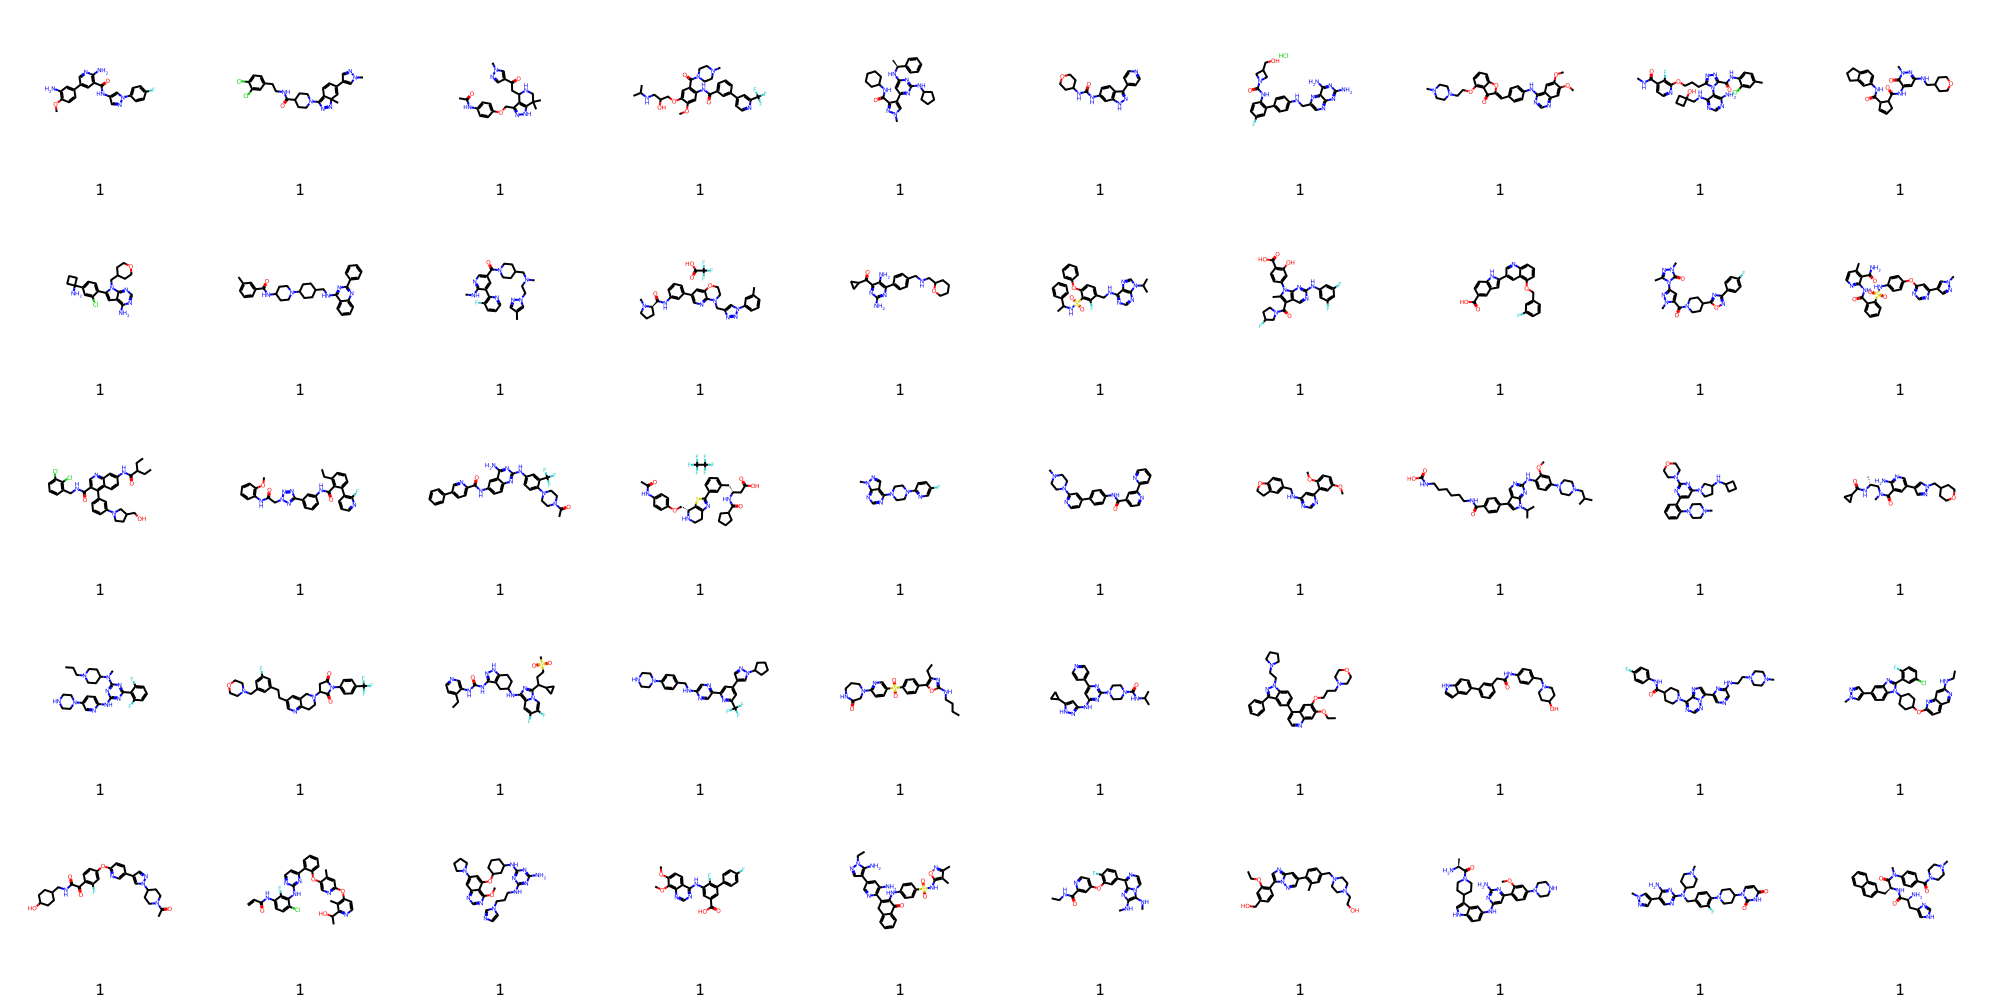

Number of SMILES with prediction 1: 152 out of 370


In [4]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors, rdPartialCharges, Draw
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import logging
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassConfusionMatrix
from tqdm import tqdm
import sys


# Set device for computation (GPU if available, otherwise CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Calculate with: {torch.cuda.get_device_name(0)}")

else:
    device = torch.device("cpu")
    print(f"Calculate with: {device}")


# Function to calculate descriptors for a given SMILES string
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # If the SMILES string is invalid, return None
    
    descriptors = {
        "MorganFingerprint":    AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048),
        "AlogP":                Descriptors.MolLogP(mol),
        "PolarSurfaceArea":     Descriptors.TPSA(mol),
        "HBA":                  Descriptors.NumHAcceptors(mol),
        "HBD":                  Descriptors.NumHDonors(mol),
        "Chi0":                 Descriptors.Chi0(mol),
        "Kappa1":               Descriptors.Kappa1(mol),
        "TPSA":                 Descriptors.TPSA(mol),
        "MolLogP":              Descriptors.MolLogP(mol),
        "PEOE_VSA1":            Descriptors.PEOE_VSA1(mol),
        "PEOE_VSA2":            Descriptors.PEOE_VSA2(mol),
        "PEOE_VSA3":            Descriptors.PEOE_VSA3(mol),
        "PEOE_VSA4":            Descriptors.PEOE_VSA4(mol),
        "PEOE_VSA5":            Descriptors.PEOE_VSA5(mol),
        "PEOE_VSA6":            Descriptors.PEOE_VSA6(mol),
        "PEOE_VSA7":            Descriptors.PEOE_VSA7(mol),
        "PEOE_VSA8":            Descriptors.PEOE_VSA8(mol),
        "PEOE_VSA9":            Descriptors.PEOE_VSA9(mol),
        "PEOE_VSA10":           Descriptors.PEOE_VSA10(mol),
        "PEOE_VSA11":           Descriptors.PEOE_VSA11(mol),
        "PEOE_VSA12":           Descriptors.PEOE_VSA12(mol),
        "PEOE_VSA13":           Descriptors.PEOE_VSA13(mol),
        "PEOE_VSA14":           Descriptors.PEOE_VSA14(mol),
        "MolecularWeight":      Descriptors.MolWt(mol),
        "NumRotatableBonds":    Descriptors.NumRotatableBonds(mol),
        "NumAromaticRings":     Descriptors.NumAromaticRings(mol),
        #"MaxPartialCharge":     max_partial_charge,
        #"MinPartialCharge":     min_partial_charge,
        "FractionCSP3":         Descriptors.FractionCSP3(mol),
        #"RadiusOfGyration":     rdMolDescriptors.CalcRadiusOfGyration(mol),
        #"Polarizability":       rdMolDescriptors.CalcExactMolWt(mol),
        #"MolVolume":            Descriptors.MolWt(mol),
        #"MolWt":                Descriptors.MolWt(mol),
        "HeavyAtomCount":       Descriptors.HeavyAtomCount(mol),
        "NHOHCount":            Descriptors.NHOHCount(mol),
        "NOCount":              Descriptors.NOCount(mol),
        "NumHeteroatoms":       Descriptors.NumHeteroatoms(mol),
        "NumRadicalElectrons":  Descriptors.NumRadicalElectrons(mol),
        "NumValenceElectrons":  Descriptors.NumValenceElectrons(mol),
        "RingCount":            Descriptors.RingCount(mol),
        "BalabanJ":             Descriptors.BalabanJ(mol),
        "BertzCT":              Descriptors.BertzCT(mol),
        "Chi1":                 Descriptors.Chi1(mol),
        "Chi0n":                Descriptors.Chi0n(mol),
        "Chi0v":                Descriptors.Chi0v(mol),
        "Chi1n":                Descriptors.Chi1n(mol),
        "Chi1v":                Descriptors.Chi1v(mol),
        "Kappa2":               Descriptors.Kappa2(mol),
        "Kappa3":               Descriptors.Kappa3(mol),
        "HallKierAlpha":        Descriptors.HallKierAlpha(mol),
    }
    return descriptors


# Define model architecture
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 8)
        self.bn5 = nn.BatchNorm1d(8)
        self.fc6 = nn.Linear(8, 2)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x


# Prediction function for new SMILES
def predict_new_smiles(smiles_list, model_path, input_size):
    """
    Predicts the class labels for a list of SMILES strings using a pre-trained model.

    Args:
        smiles_list (list of str): List of SMILES strings to predict.
        model_path (str): Path to the pre-trained model file.
        input_size (int): Number of features expected by the model.

    Returns:
        torch.Tensor: The predicted class labels for the input SMILES strings.
    """
    # Ensure the model architecture matches the saved model
    model = MLP(input_size)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()


    # Calculate descriptors for the new SMILES
    data = [calculate_descriptors(smiles) for smiles in smiles_list]
    df_new = pd.DataFrame(data)
    
    # Handle cases where the SMILES string is invalid
    if 'MorganFingerprint' not in df_new.columns:
        raise ValueError("MorganFingerprint column missing. Ensure valid SMILES strings are provided.")

    fingerprints = np.array([list(fp) for fp in df_new["MorganFingerprint"].values])
    fingerprints_df = pd.DataFrame(fingerprints, columns=[f"FP_{i}" for i in range(fingerprints.shape[1])])
    df_new = df_new.drop(columns=["MorganFingerprint"])
    df_new = pd.concat([df_new, fingerprints_df], axis=1)


    # Ensure the number of features matches the input size of the model
    if df_new.shape[1] != input_size:
        raise ValueError(f"Number of features does not match: {df_new.shape[1]} instead of {input_size}")

    new_tensor = torch.tensor(df_new.values, dtype=torch.float32).to(device)

    # Make predictions
    with torch.no_grad():
        predictions = model(new_tensor)
        predicted_classes = torch.argmax(predictions, dim=1)

    return predicted_classes


# Function to read SMILES from a file
def read_smiles_from_file(file_path):
    """
    Reads SMILES strings from a text file.
    Args:
        file_path (str): Path to the file containing SMILES strings.
    Returns:
        list of str: List of SMILES strings.
    """
    with open(file_path, 'r') as file:
        return file.read().splitlines()


# Function to read existing SMILES from a database file
def read_existing_smiles(db_file_path):
    """
    Reads existing SMILES strings from a database file.
    Args:
        db_file_path (str): Path to the database file.
    Returns:
        set of str: Set of existing SMILES strings.
    """
    if os.path.exists(db_file_path):
        with open(db_file_path, 'r') as db_file:
            return set(db_file.read().splitlines())
    return set()


# Function to save new SMILES predicted as 1 (AXL inhibitors) to the database
def save_smiles_to_db(smiles_list, predictions, db_file_path):
    """
    Saves SMILES strings that are predicted as 1 (AXL inhibitors) to a database.
    Args:
        smiles_list (list of str): List of SMILES strings.
        predictions (torch.Tensor): Predicted classes for each SMILES.
        db_file_path (str): Path to the database file.
    """
    existing_smiles = read_existing_smiles(db_file_path)
    with open(db_file_path, 'a') as db_file:
        for smiles, pred in zip(smiles_list, predictions):
            if int(pred) == 1 and smiles not in existing_smiles:
                db_file.write(smiles + '\n')
                existing_smiles.add(smiles)


# Function to draw SMILES
def draw_smiles(smiles_list, predictions, filter_values, db_file_path):
    """
    Draws and displays SMILES structures, filtering by prediction values.
    Args:
        smiles_list (list of str): List of SMILES strings.
        predictions (torch.Tensor): Predicted classes for each SMILES.
        filter_values (str): Comma-separated list of class values to filter by.
        db_file_path (str): Path to the database file for saving filtered SMILES.
    """
    filter_set = set(map(int, filter_values.split(',')))
    filtered_smiles = [smiles for smiles, pred in zip(smiles_list, predictions) if int(pred) in filter_set]
    molecules = [Chem.MolFromSmiles(smiles) for smiles in filtered_smiles]
    legends = [str(pred.item()) for pred in predictions if int(pred) in filter_set]
    img = Draw.MolsToGridImage(molecules, molsPerRow=10, subImgSize=(200, 200), legends=legends)
    display(img)

    
    # Save filtered SMILES to database
    save_smiles_to_db(smiles_list, predictions, db_file_path)
    count_ones = sum(int(pred) == 1 for pred in predictions)
    print(f"Number of SMILES with prediction 1: {count_ones} out of {len(predictions)}")



# Execution block
if __name__ == "__main__":

    # File paths and parameters
    file_path = 'C:\\Users\\SchockWav3\\Desktop\\Masterarbeit\\generated_smiles_1906.txt'
    db_file_path = 'C:\\Users\\SchockWav3\\Desktop\\Masterarbeit\\database_potential_axl_inhibitors.txt'
    model_path = 'C:\\Users\\SchockWav3\\Desktop\\Masterarbeit\\modelle\\model_predictor_0608_final.pth'
    input_size = 2048 + 43  # Adjust based on the actual number of features (MorganFingerprints + Descriptors)
    

    # Read user SMILES and make predictions
    user_smiles = read_smiles_from_file(file_path)
    predictions = predict_new_smiles(user_smiles, model_path, input_size)
    
    
    # Draw SMILES predicted as 1 (AXL inhibitors) or 0
    draw_smiles(user_smiles, predictions, "1", db_file_path)

Displays all potential SMILES from the database

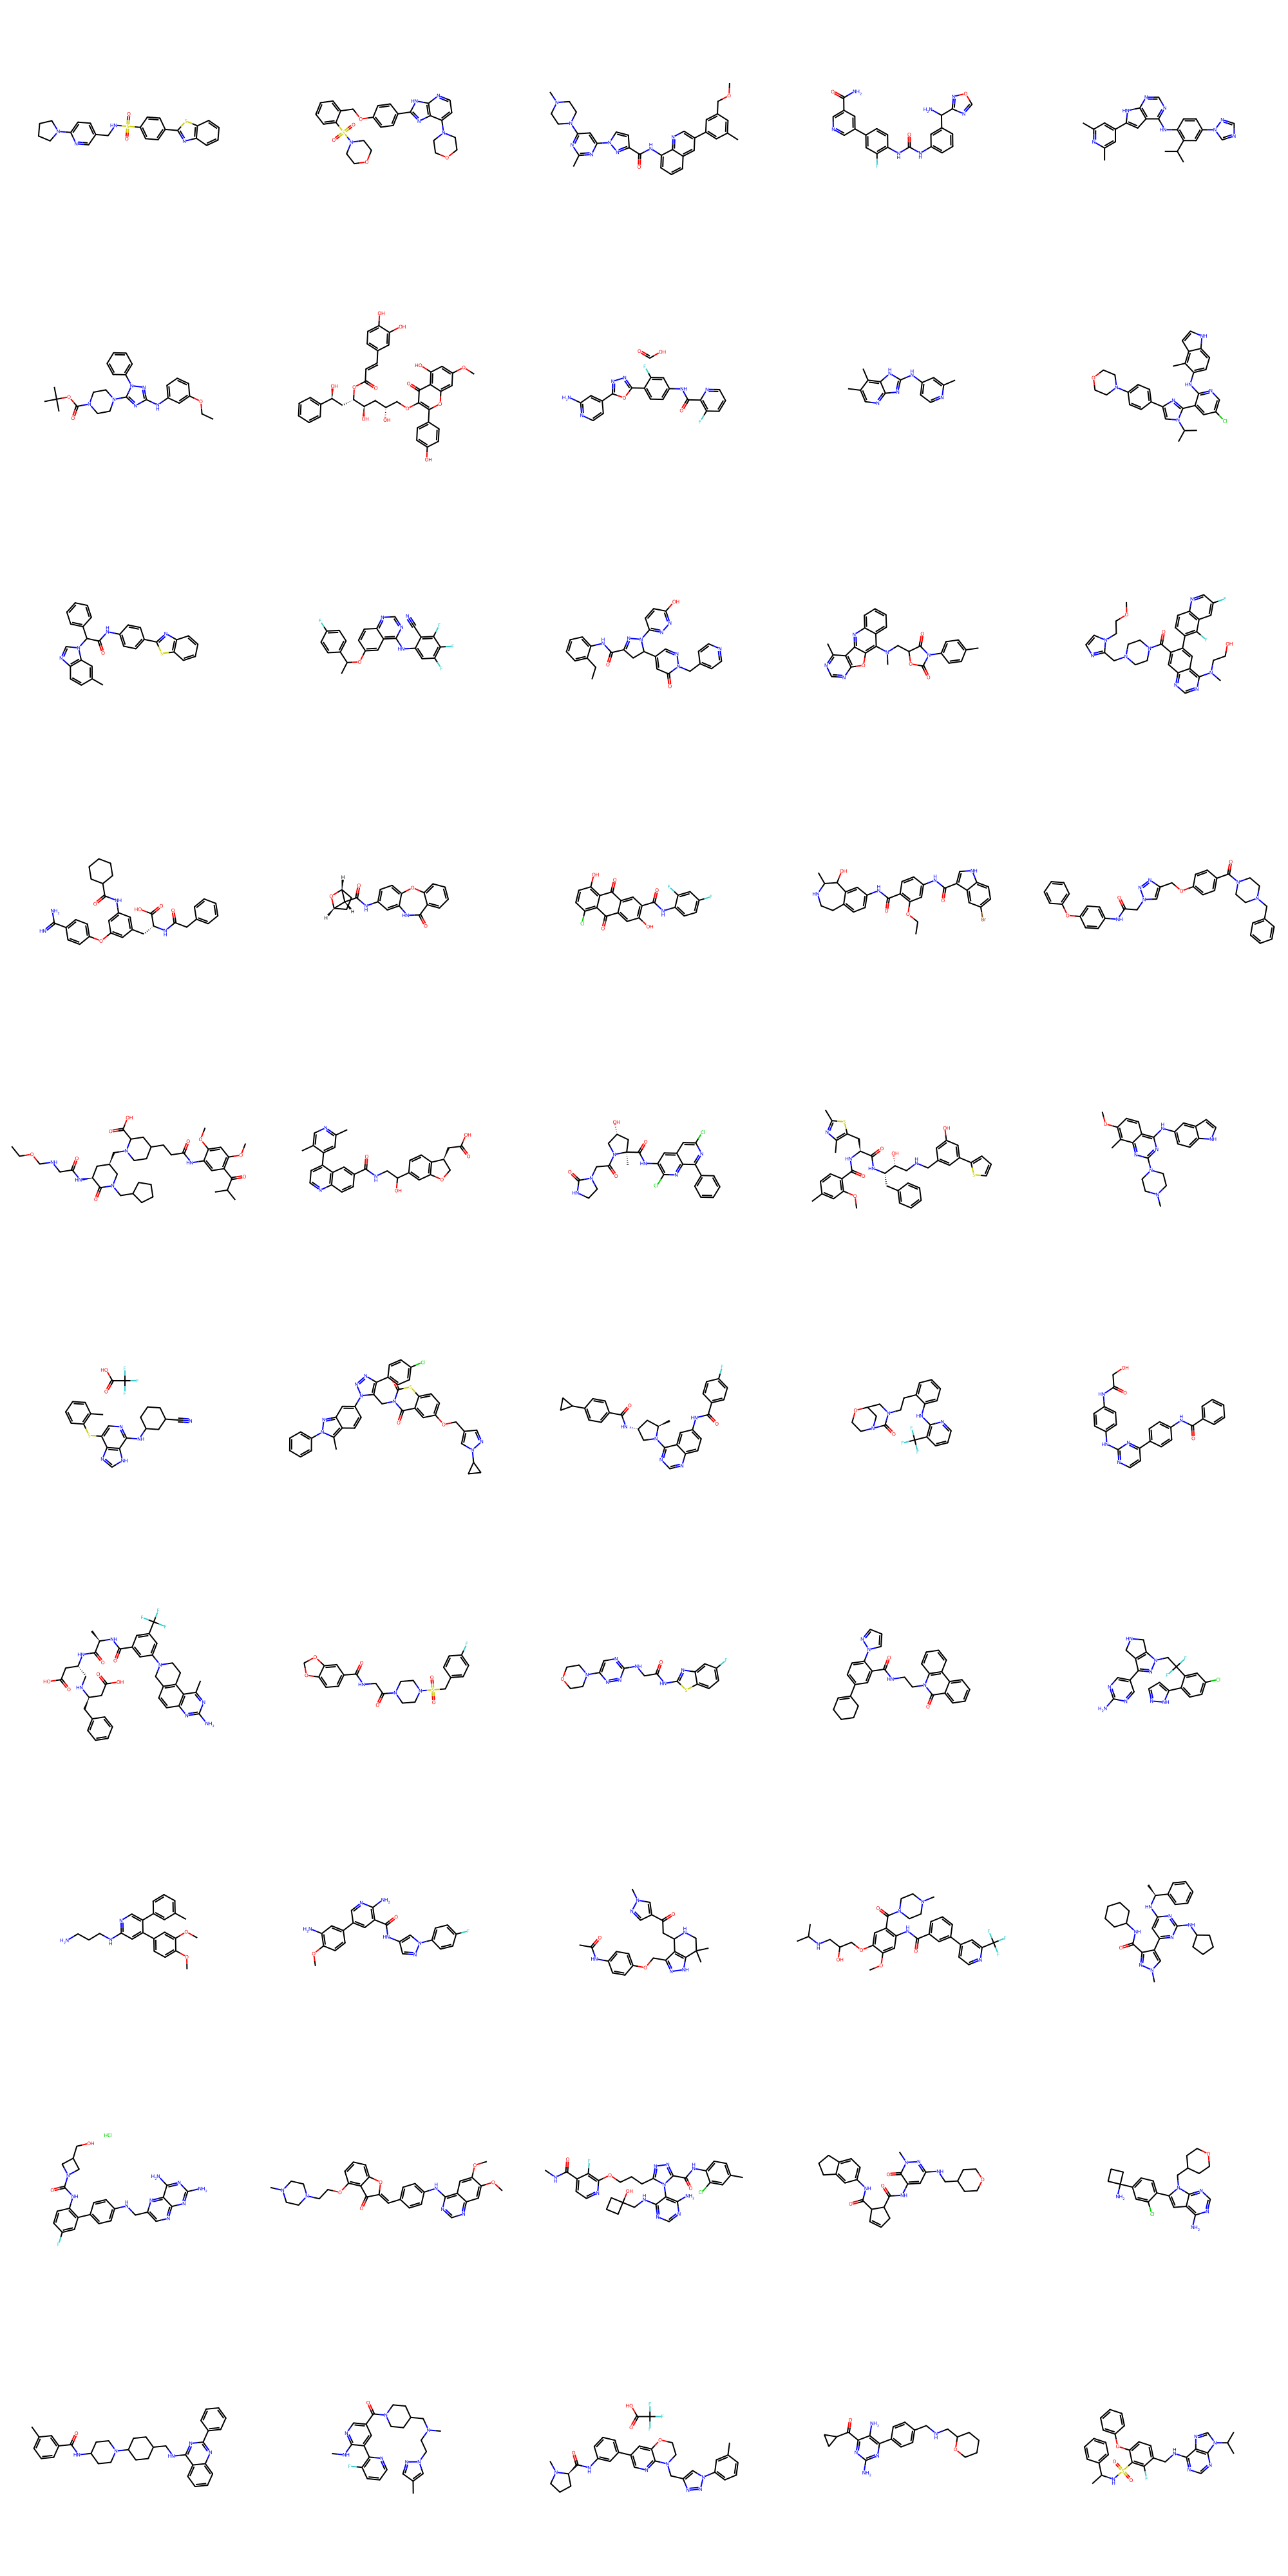

In [6]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors, rdPartialCharges, Draw
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import logging
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassConfusionMatrix
from tqdm import tqdm
import sys


# Function to read SMILES from the database file
def read_smiles_from_db(db_file_path):
    """
    Reads SMILES strings from a database file.
    Args:
        db_file_path (str): Path to the database file.
    Returns:
        list of str: List of SMILES strings from the database.
    """
    with open(db_file_path, 'r') as db_file:
        smiles_list = db_file.read().splitlines()
    return smiles_list


# Function to draw SMILES from the database
def draw_smiles_from_db(smiles_list):
    """
    Draws SMILES structures from a given list of SMILES strings.
    Args:
        smiles_list (list of str): List of SMILES strings to be visualized.
    Returns:
        None: Displays an image grid of the molecular structures.
    """
    molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    img = Draw.MolsToGridImage(molecules, molsPerRow=5, subImgSize=(400, 400))
    display(img)


# Define the database file path
db_file_path = 'C:\\Users\\SchockWav3\\Desktop\\Masterarbeit\\database_potential_axl_inhibitors.txt'


# Read SMILES from the database
smiles_from_db = read_smiles_from_db(db_file_path)


# Draw the SMILES structures from the database
draw_smiles_from_db(smiles_from_db)
